In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib qt
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [3]:
import sys
# sys.path.append('../')
sys.path.append('../')
sys.path.append('../model')
sys.path.append('../cost')
sys.path.append('../constraints')
sys.path.append('../utils')
import Landing3DModel
import Landing3DCost
import Landing3DConstraints
from scipy.integrate import solve_ivp
from Scvx import Scvx

In [4]:
def euler_to_quaternion(attitude):
    roll, pitch, yaw = attitude[0],attitude[1],attitude[2]
    qx = np.sin(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) - np.cos(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    qy = np.cos(roll/2) * np.sin(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.cos(pitch/2) * np.sin(yaw/2)
    qz = np.cos(roll/2) * np.cos(pitch/2) * np.sin(yaw/2) - np.sin(roll/2) * np.sin(pitch/2) * np.cos(yaw/2)
    qw = np.cos(roll/2) * np.cos(pitch/2) * np.cos(yaw/2) + np.sin(roll/2) * np.sin(pitch/2) * np.sin(yaw/2)
    return [qw, qx, qy, qz]

def quaternion_to_euler(w, x, y, z):

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = np.arctan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch_y = np.arcsin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw_z = np.arctan2(t3, t4)

    return roll_x, pitch_y, yaw_z

In [5]:
ix = 14
iu = 3
ih = 7
tf = 5
N = 30
delT = tf/N
max_iter = 15

In [16]:
ei = np.array([np.deg2rad(15),np.deg2rad(0),0])
qi = euler_to_quaternion(ei)
xi = np.array([2,    3,0,3,     0.0,0.0,-1,         qi[0],qi[1],qi[2],qi[3],   0,0,0])
xf = np.array([1,    0,0,0,     0.0,0.0,-0.1,       1,0,0,0,                   0,0,0])

myModel = Landing3DModel.Landing3D('Hello',ix,iu,delT,linearization="analytic")
myCost = Landing3DCost.Landing3D('Hello',ix,iu,N)
myConst = Landing3DConstraints.Landing3D('Hello',ix,iu)

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i,0:7] = (N-i)/N * xi[0:7] + i/N * xf[0:7]
    x0[i,7:11] = euler_to_quaternion( (N-i)/N * ei + i/N * np.zeros(3))
    x0[i,11:] = (N-i)/N * xi[11:] + i/N * xf[11:]

u0 = np.zeros((N+1,iu))
u0[:,2] = x0[:,0] * 1

In [25]:
i1 = Scvx('unicycle',N,max_iter,myModel,myCost,myConst,
          type_discretization='zoh',w_c=1,w_vc=1e4,w_tr=1e1,tol_vc=1e-4,flag_policyopt=False)
x,u,xbar,ubar,total_num_iter,flag_boundary,l,l_vc,l_tr = i1.run(x0,u0,xi,xf)

iteration   total_cost  cost        ||vc||     ||tr||       reduction   expected    w_tr        bounary
1           2076.857713 -1.890733   0.0386      169         -2.08e+03   -2.08e+03   10.000000   0(6.15)
2           82.817289   -1.879487   5.02e-05    8.42        1.99e+03    1.99e+03    10.000000   0(1.34)
non-positive expected reduction
3           577.456854  -1.863854   0.028       29.9        -495        -495        10.000000   0(0.271)
4           36.406116   -1.860792   4.4e-05     3.78        541         541         10.000000   0(0.0428)
5           -1.471452   -1.860012   3.73e-05    0.00158     37.9        37.9        10.000000   1(0.00029)
6           -1.487922   -1.860013   3.72e-05    2.99e-06    0.0165      0.0165      10.000000   1(0.000254)
SUCCEESS: virtual control and trust region < tol


In [26]:
# xbar,ubar = x,u

In [27]:
list_time = delT * np.array([i for i in range(N+1)])
u_norm = np.linalg.norm(ubar,axis=1)
x_norm_12 = np.linalg.norm(xbar[:,1:3],axis=1)
glide_slope_angle = np.arctan(xbar[:,3]/x_norm_12)
tilt_angle = np.arccos(1 - 2 * (xbar[:,8]**2+xbar[:,9]**2))
gimbal_angle = np.arccos(ubar[:,2] / u_norm)

In [28]:
from utils_plot import plot_rocket3d
%matplotlib qt
# %matplotlib inline
fig = plt.figure(1,figsize=(15,15))
plot_rocket3d(fig,xbar,ubar,x)

(0.0, 100.0)

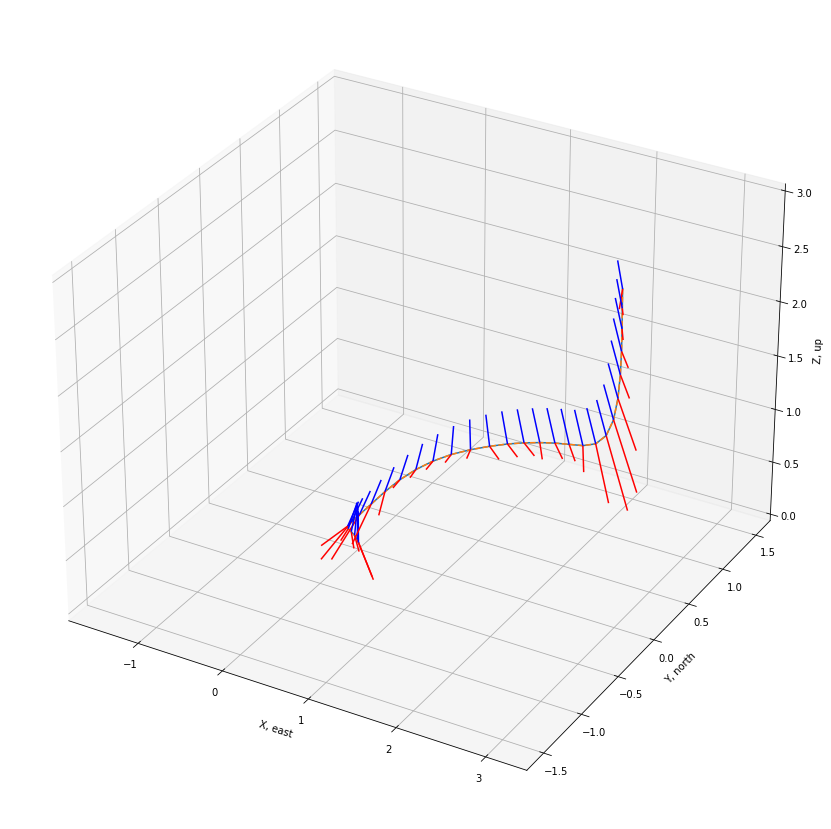

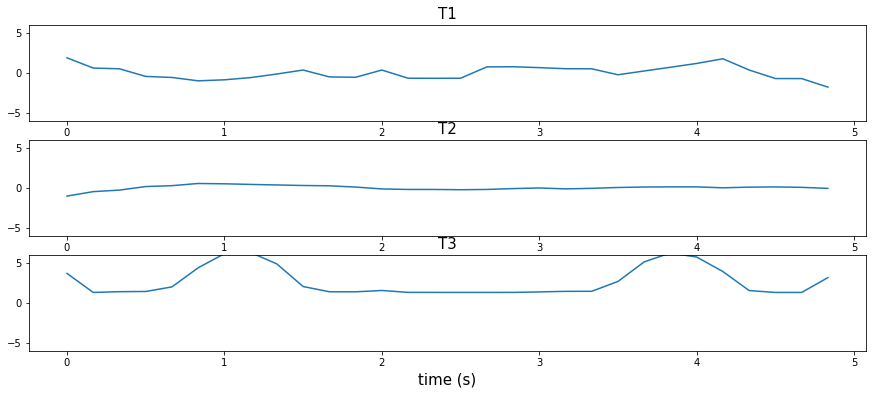

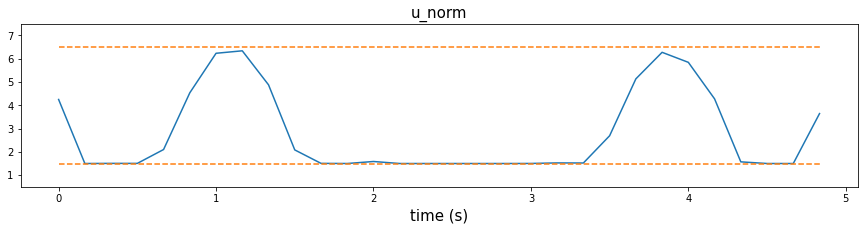

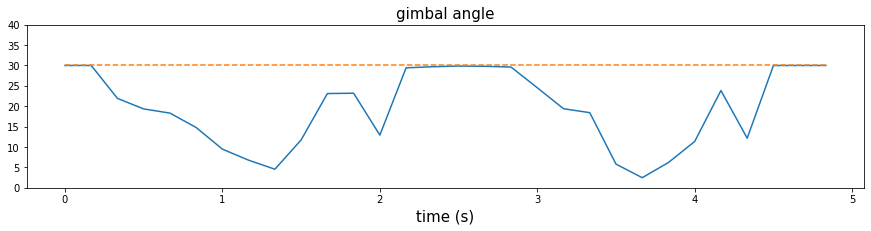

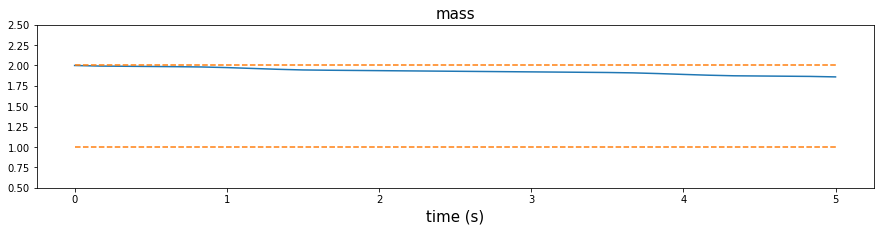

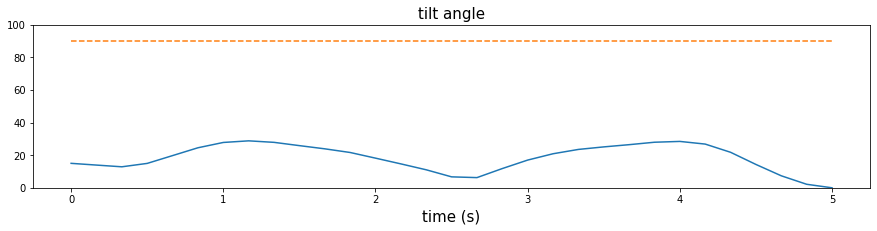

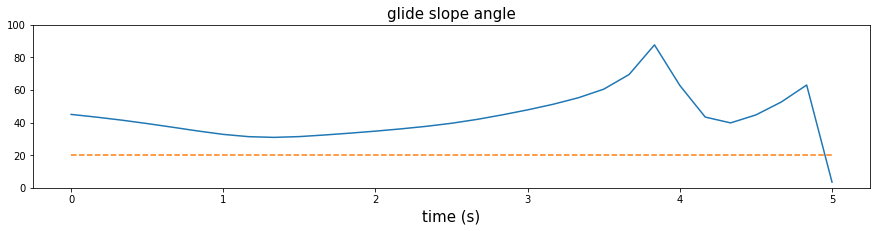

In [29]:
%matplotlib inline
from utils_plot import make_rocket3d_trajectory_fig
fig = plt.figure(1,figsize=(15,15))
plot_rocket3d(fig,xbar,ubar,x)

fS = 15
plt.figure(figsize=(15,6))
plt.subplot(311)
plt.plot(list_time[:N],ubar[:N,0])
plt.xlabel('time (s)',fontsize=fS)
plt.ylim([-6,6])
plt.title('T1',fontsize=fS)
plt.subplot(312)
plt.plot(list_time[:N],ubar[:N,1])
plt.xlabel('time (s)',fontsize=fS)
plt.ylim([-6,6])
plt.title('T2',fontsize=fS)
plt.subplot(313)
plt.plot(list_time[:N],ubar[:N,2])
plt.xlabel('time (s)',fontsize=fS)
plt.ylim([-6,6])
plt.title('T3',fontsize=fS)

plt.figure(figsize=(15,3))
plt.plot(list_time[:N],u_norm[:N])
plt.plot(list_time[:N],list_time[:N]*0+myConst.T_max,'--',color='tab:orange')
plt.plot(list_time[:N],list_time[:N]*0+myConst.T_min,'--',color='tab:orange')
plt.xlabel('time (s)',fontsize=fS)
plt.ylim([-1+myConst.T_min,myConst.T_max+1])
plt.title('u_norm',fontsize=fS)

plt.figure(figsize=(15,3))
plt.plot(list_time[:N],np.rad2deg(gimbal_angle[:N]))
plt.plot(list_time[:N],list_time[:N]*0+np.rad2deg(myConst.delta_max),'--',color='tab:orange')
plt.xlabel('time (s)',fontsize=fS)
plt.title('gimbal angle',fontsize=fS)
plt.ylim([0,np.rad2deg(myConst.delta_max)+10])

plt.figure(figsize=(15,3))
plt.plot(list_time,xbar[:,0])
plt.plot(list_time,list_time*0+2,'--',color='tab:orange')
plt.plot(list_time,list_time*0+myConst.m_dry,'--',color='tab:orange')
plt.xlabel('time (s)',fontsize=fS)
plt.title('mass',fontsize=fS)
plt.ylim([-0.5+myConst.m_dry,2+0.5])

plt.figure(figsize=(15,3))
plt.plot(list_time,np.rad2deg(tilt_angle))
plt.plot(list_time,list_time*0+np.rad2deg(myConst.theta_max),'--',color='tab:orange')
plt.xlabel('time (s)',fontsize=fS)
plt.title('tilt angle',fontsize=fS)
plt.ylim([0,np.rad2deg(myConst.theta_max)+10])

plt.figure(figsize=(15,3))
plt.plot(list_time,np.rad2deg(glide_slope_angle))
plt.plot(list_time,list_time*0+np.rad2deg(myConst.gamma_gs),'--',color='tab:orange')
plt.xlabel('time (s)',fontsize=fS)
plt.title('glide slope angle',fontsize=fS)
plt.ylim([0,100])


In [ ]:
# make_rocket3d_trajectory_fig(x,u,'Landing3D')